In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torchvision import models, transforms, utils
from torchvision.transforms.functional import normalize, resize, to_pil_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
train_df = pd.read_csv('DDR-dataset/DR_grading/train.txt', sep=' ', header=None, names=['image', 'label'])
train_df = train_df.query('label != 5')
train_df['path'] = train_df['image'].apply(lambda x: os.path.join('DDR-dataset/DR_grading/train_preprocessed', x))

val_df = pd.read_csv('DDR-dataset/DR_grading/valid.txt', sep=' ', header=None, names=['image', 'label'])
val_df = val_df.query('label != 5')
val_df['path'] = val_df['image'].apply(lambda x: os.path.join('DDR-dataset/DR_grading/valid_preprocessed', x))

test_df = pd.read_csv('DDR-dataset/DR_grading/test.txt', sep=' ', header=None, names=['image', 'label'])
test_df = test_df.query('label != 5')
test_df['path'] = test_df['image'].apply(lambda x: os.path.join('DDR-dataset/DR_grading/test_preprocessed', x))

In [3]:
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [4]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

x_train = train_df['path']
y_train = train_df['label']
x_val = val_df['path']
y_val = val_df['label']
x_test = test_df['path']
y_test = test_df['label']

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, paths, label, transform=None):
        self.paths = paths
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.label[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transformations
aug_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=360),
    v2.RandomPerspective(distortion_scale=0, p=1, interpolation=3),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
])

# Define the main transformation pipeline
train_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomApply([aug_transforms], p=0.5),  # Apply augmentations with 50% probability
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create custom datasets and dataloaders for training and validation
train_dataset = CustomImageDataset(x_train,y_train, transform=train_transform)
val_dataset = CustomImageDataset(x_val,y_val, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(x_test,y_test, transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


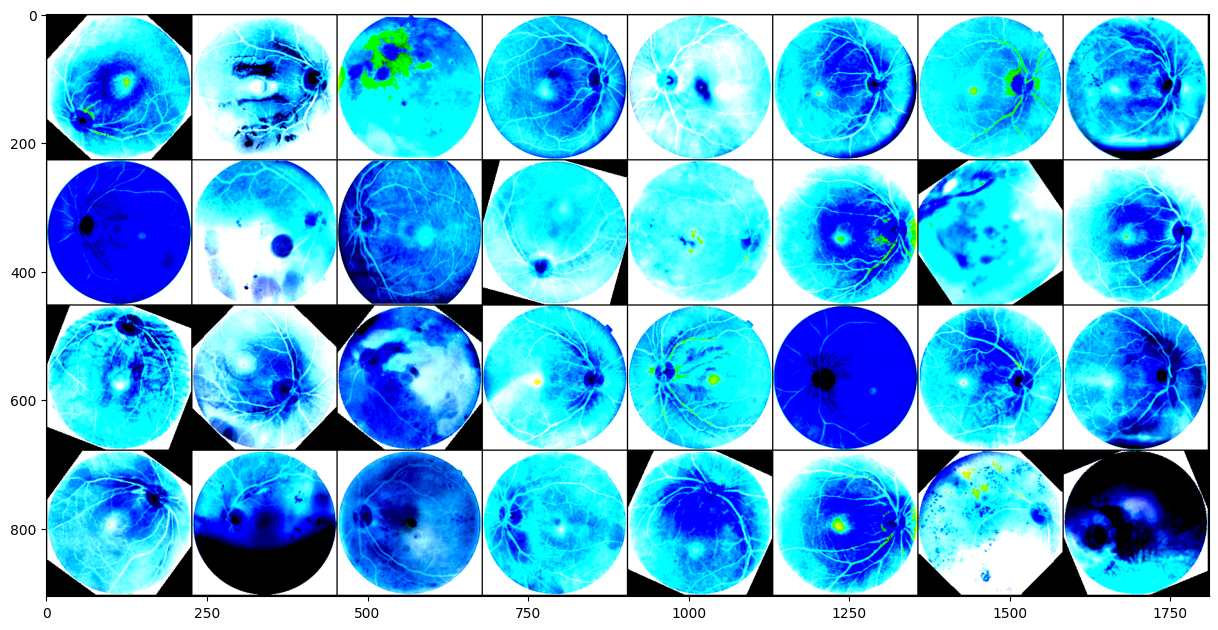

In [6]:
def show_batch(batch):
    images, labels = batch
    grid_img = utils.make_grid(images, nrow=8)
    grid_img = np.transpose(grid_img, (1, 2, 0))
    # print(images.size())
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img)
    plt.show()

# Iterate over the train_dataloader and visualize a batch
for batch in train_dataloader:
    show_batch(batch)
    break  # Stop after visualizing the first batch

In [7]:
from torch.nn.parameter import Parameter
import torch.nn.functional as F
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


In [ ]:
# Load pre-trained EfficientNet-B7
model = EfficientNet.from_pretrained('efficientnet-b7')

# Modify the final fully connected layer for your specific classification task
num_classes = 5  # Assuming you have 5 classes
model._fc = nn.Linear(model._fc.in_features, num_classes)
   
model.avgpool = GeM()

# Define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
loss_func = nn.CrossEntropyLoss()

# Move the model to GPU if available
model.to(device)

best_acc = 0

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()


    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += loss_func(outputs, labels).item()

            all_preds.append(outputs.cpu().detach().numpy())
            all_labels.append(labels.cpu().detach().numpy())

    val_loss /= len(val_dataloader)
        
    # Flatten predictions and labels for Quadratic Weighted Kappa calculation
    all_preds = np.concatenate(all_preds).argmax(axis=1)
    all_labels = np.concatenate(all_labels)


    # Calculate Quadratic Weighted Kappa
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    
    acc = accuracy_score(all_labels, all_preds)
    if acc > best_acc:
        best_acc = acc
        print('saving model')
        torch.save(model.state_dict(), 'DDRefficientnetB7_best_acc.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, QWK: {qwk:.4f}, Acc: {acc:.4f}')

In [8]:
model = EfficientNet.from_pretrained('efficientnet-b7')
num_classes = 5  # Assuming you have 5 classes
model._fc = nn.Linear(model._fc.in_features, num_classes)
model.avgpool = GeM()
model.load_state_dict(torch.load('Models/DDR Efficientnet B7 best acc.pth', map_location=device))

all_preds = []
all_labels = []
all_probs = []
model.to(device)
model.eval()

# No need to track gradients for test
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        all_preds.append(outputs.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
        all_probs.append(F.softmax(outputs, dim=1).cpu().detach().numpy())
all_preds = np.concatenate(all_preds).argmax(axis=1)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /Users/aarshpatel/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:07<00:00, 36.9MB/s] 


Loaded pretrained weights for efficientnet-b7


Accuracy: 0.8412
Error Rate: 0.1588
QWK: 0.8513
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       627
           1       0.45      0.14      0.22        63
           2       0.83      0.83      0.83       448
           3       0.39      0.52      0.44        23
           4       0.95      0.75      0.84        92

    accuracy                           0.84      1253
   macro avg       0.70      0.64      0.65      1253
weighted avg       0.83      0.84      0.83      1253

Geometric Mean: 0.8674


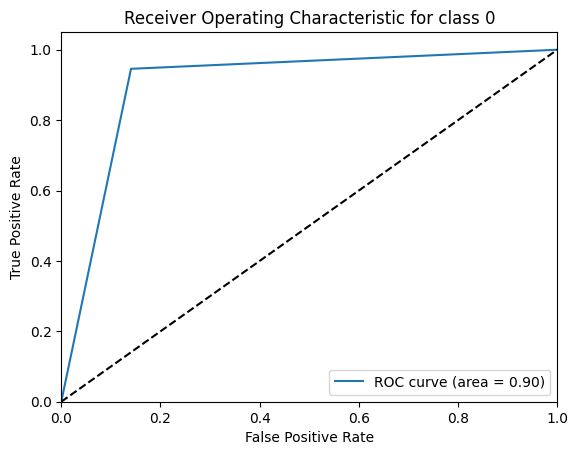

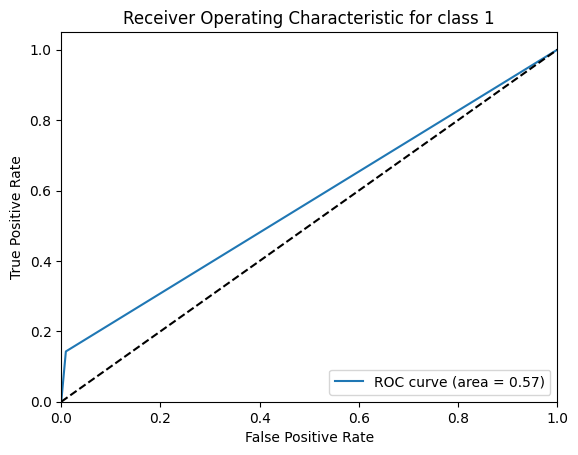

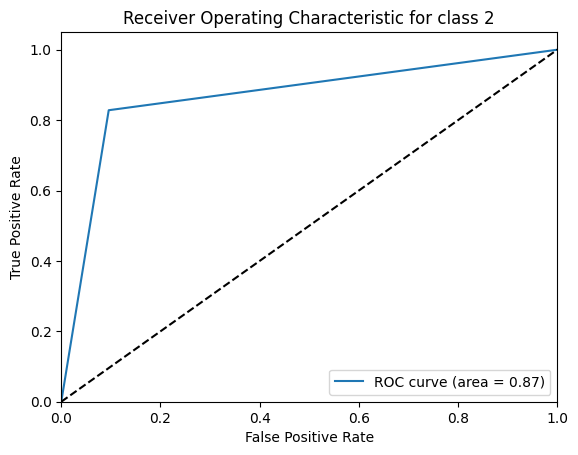

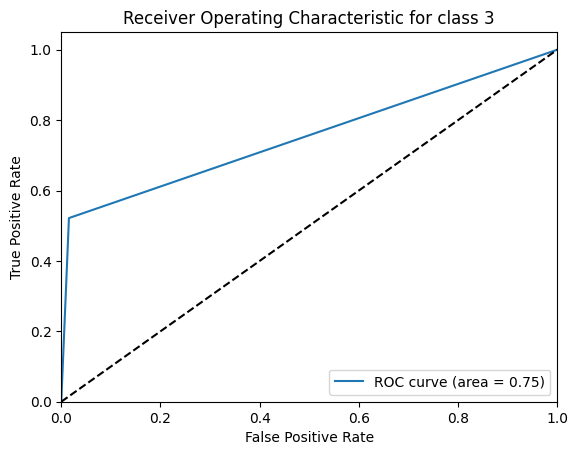

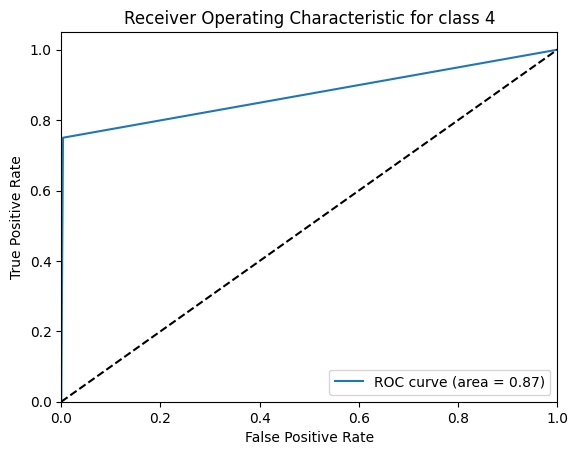

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from imblearn.metrics import geometric_mean_score
import matplotlib.pyplot as plt

# Calculate metrics
acc = accuracy_score(all_labels, all_preds)
error_rate = 1 - acc
report = classification_report(all_labels, all_preds, zero_division=0)
qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

# Print metrics
print(f'Accuracy: {acc:.4f}')
print(f'Error Rate: {error_rate:.4f}')
print(f'QWK: {qwk:.4f}')
print(report)

# Calculate Geometric Mean
gmean = geometric_mean_score(all_labels, all_preds, average='weighted')
print(f'Geometric Mean: {gmean:.4f}')

# Calculate ROC AUC for each class
lb = LabelBinarizer()
lb.fit(all_labels)
lb_labels = lb.transform(all_labels)
lb_preds = lb.transform(all_preds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(lb_labels[:, i], lb_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()